In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

from IPython.display import HTML, display

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
from numpy import linspace
from matplotlib.colors import LogNorm

Minimum Final Std Dev: Trajectory 7 (0.009101)
Minimum AVG Future Std Dev: Trajectory 22 (0.142291)


,T 0,T 1,T 2,T 3,T 4,T 5,T 6,T 7,T 8,T 9,T 10,T 11,T 12,T 13,T 14,T 15,T 16,T 17,T 18,T 19,T 20,T 21,T 22,T 23,T 24,T 25,T 26,T 27,T 28,T 29,T 30,T 31,T 32,T 33,T 34,T 35,T 36,T 37,T 38,T 39,T 40,T 41,T 42,T 43,T 44,T 45,T 46,T 47,T 48,T 49,T 50,T 51,T 52,T 53
Voxels,17,19,21,18,19,21,20,19,22,19,19,23,20,21,23,19,21,23,20,21,23,22,22,25,22,21,24,24,23,26,22,23,25,24,25,27,24,25,27,24,24,27,25,24,28,26,25,28,25,27,29,25,26,29
Last AVG Std,0.014,0.014,0.016,0.012,0.019,0.024,0.015,0.009,0.029,0.021,0.015,0.021,0.019,0.025,0.033,0.015,0.012,0.020,0.011,0.017,0.016,0.013,0.013,0.017,0.025,0.021,0.036,0.025,0.011,0.016,0.016,0.017,0.031,0.020,0.023,0.035,0.030,0.017,0.020,0.021,0.020,0.020,0.020,0.012,0.022,0.018,0.020,0.018,0.021,0.021,0.023,0.021,0.020,0.025
AVG Future Std,0.160,0.165,0.173,0.155,0.171,0.169,0.158,0.162,0.187,0.165,0.185,0.177,0.206,0.211,0.222,0.186,0.191,0.193,0.146,0.148,0.166,0.164,0.142,0.155,0.185,0.188,0.203,0.184,0.152,0.167,0.174,0.176,0.203,0.194,0.193,0.199,0.187,0.165,0.182,0.173,0.183,0.174,0.166,0.161,0.193,0.161,0.182,0.182,0.189,0.191,0.175,0.178,0.183,0.187


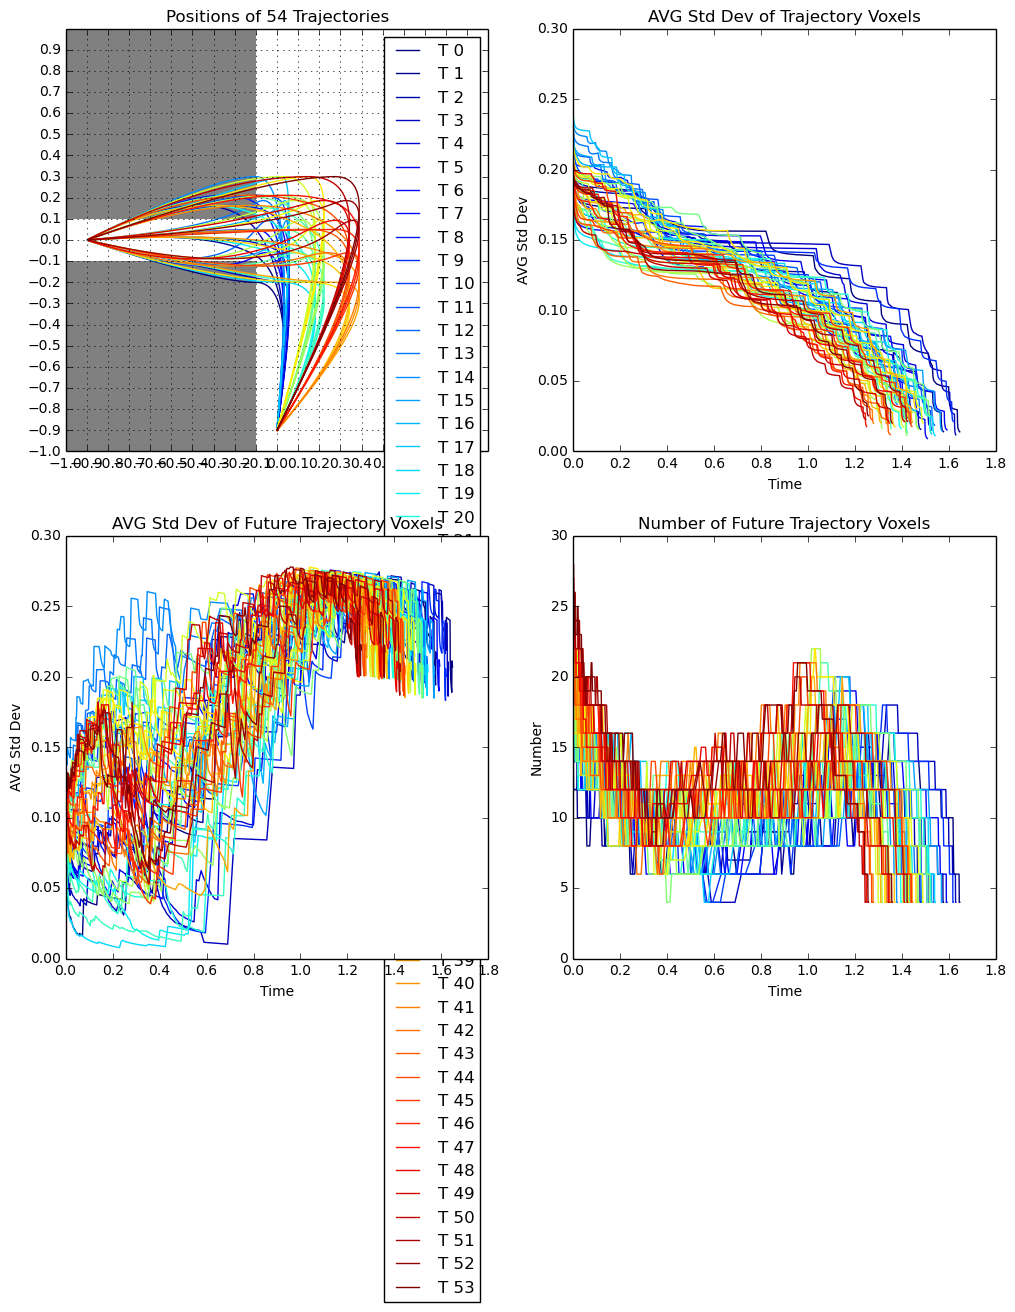

In [54]:
%matplotlib inline

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
verts1 = [
    (-1, -1), # left, bottom
    (-1, -.1), # left, top
    (-.1, -.1), # right, top
    (-.1, -1), # right, bottom
    (0., 0.), # ignored
]

verts2 = [
    (-1, .1), # left, bottom
    (-1, 1), # left, top
    (-.1, 1), # right, top
    (-.1, .1), # right, bottom
    (0., 0.), # ignored
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

ax1.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
ax1.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
ax1.set_xticks(np.arange(-1,1,0.1))
ax1.set_yticks(np.arange(-1,1,0.1))
ax1.grid()

filenames = sorted(glob.glob("../build/trajeval/*.bag"), key=lambda f: int(re.findall('([0-9]+)', f)[0]))

cm_subsection = linspace(0, 1, len(filenames))
colors = [cm.jet(x) for x in cm_subsection]


ax1.set_title("Positions of %i Trajectories" % len(filenames))

ax2.set_title("AVG Std Dev of Trajectory Voxels")
ax2.set_xlabel("Time")
ax2.set_ylabel("AVG Std Dev")

ax3.set_title("AVG Std Dev of Future Trajectory Voxels")
ax3.set_xlabel("Time")
ax3.set_ylabel("AVG Std Dev")

ax4.set_title("Number of Future Trajectory Voxels")
ax4.set_xlabel("Time")
ax4.set_ylabel("Number")

traj_names = [""]
avg_stds = []
avg_future_stds = []
traj_voxels = []

min_std = 1.
min_stdi = -1

min_future_std = 1.
min_future_stdi = -1

for rnd, filename in enumerate(filenames):
#     if rnd != 7:
#         continue
#     if rnd != 22:
#         continue
    
    #print "Evaluating trajectory %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
        
    traj_names.append("T %i" % rnd)
    traj_voxels.append(stats.trajectoryVoxels)
        
#     start = 0
#     err0sBelief = []
#     err0sLogOdds = []
#     ax = plt.subplot(111)
#     for step in range(stats.step):
#         err0Belief = np.mean(np.array(stats.errorCompleteUpdatedBelief[start:start + stats.updatedVoxels[step]]))
#         err0sBelief.append(err0Belief)
#         err0LogOdds = np.mean(np.array(stats.errorCompleteUpdatedLogOdds[start:start + stats.updatedVoxels[step]]))
#         err0sLogOdds.append(err0LogOdds)
#         start += stats.updatedVoxels[step]
#     ax.plot(err0sBelief, label="SMAP")
#     ax.plot(err0sLogOdds, label="LogOdds")

#     if rnd == 5:
#         ax1.plot(stats.trajectoryX, stats.trajectoryY, label="T %i" % rnd, c=colors[rnd])
    ax1.plot(stats.trajectoryX, stats.trajectoryY, label="T %i" % rnd, c=colors[rnd])
    
    ax1.legend()
    
    stats.trajectoryTime = stats.trajectoryTime[:-2]
    
    #ax2.plot(stats.trajectoryTime)
    std = np.array(stats.trajectoryStdDevsBelief).reshape((-1, stats.trajectoryVoxels))
    avg_std = np.mean(std, axis=1)[:-2]
    ax2.plot(stats.trajectoryTime, avg_std, c=colors[rnd])
    
    avg_stds.append(avg_std[-1])
    
    if avg_std[-1] < min_std:
        min_std = avg_std[-1]
        min_stdi = rnd        
        
    # future std
    start = 0
    future_avg_stds = []
    for step in range(stats.step):
        future_std = stats.trajectoryFutureStdDevsBelief[start:start + stats.trajectoryFutureVoxels[step]]
        future_avg_stds.append(sum(future_std)*1./stats.trajectoryFutureVoxels[step])
        start += stats.trajectoryFutureVoxels[step]
        
    ax3.plot(stats.trajectoryTime, future_avg_stds[:-1], c=colors[rnd])
    
    avg_future_std = np.mean(future_avg_stds[:-1])
    avg_future_stds.append(avg_future_std)
    if avg_future_std < min_future_std:
        min_future_std = avg_future_std
        min_future_stdi = rnd
        
    
    ax4.plot(stats.trajectoryTime, stats.trajectoryFutureVoxels[:-2], c=colors[rnd])

print "Minimum Final Std Dev: Trajectory %i (%.6f)" % (min_stdi, min_std)
print "Minimum AVG Future Std Dev: Trajectory %i (%.6f)" % (min_future_stdi, min_future_std)

data = [
    traj_names,
    ["Voxels"] + traj_voxels,
    ["Last AVG Std"] + list(map(lambda x: "%.3f" % x, avg_stds)),
    ["AVG Future Std"] + list(map(lambda x: "%.3f" % x, avg_future_stds))
]

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
 ))